# Dogs vs. Cats
derived from https://github.com/a4tunado/lectures/blob/master/cv/006/006-dogs-vs-cats.ipynb

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

### differences from the reference notebook
1. full pretrained VGG16 is used, with original prediction layer
2. added Dropout(0.144) and Dense(1) layers
3. val size = 5000
4. epochs trained = 65 (stopped)
5. optimizer=keras.optimizers.Adam(lr=0.01) (lr up from default 0.001)


In [1]:
!ls ~/.keras/models

vgg16_weights_tf_dim_ordering_tf_kernels.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
#reduce GPU memory
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [3]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

In [4]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [ ]:
np.random.seed(seed=42)

In [5]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

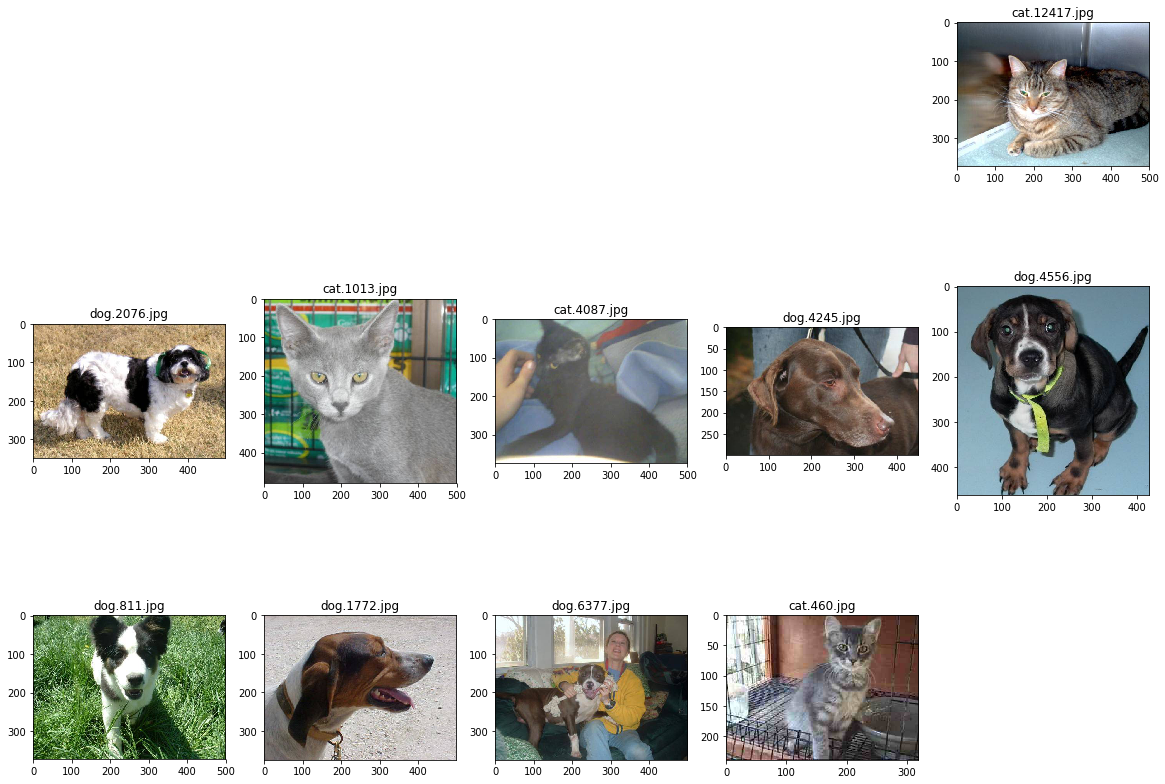

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [118]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = True, #False
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [11]:
#remove the last layer with 1000 outputs
del base_model.layers[-1:]

In [119]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [120]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
base_model.layers[-3].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc1',
 'trainable': False,
 'units': 4096,
 'use_bias': True}

In [10]:
base_model.layers[-2].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc2',
 'trainable': False,
 'units': 4096,
 'use_bias': True}

In [11]:
base_model.layers[-1].get_config()

{'activation': 'softmax',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'predictions',
 'trainable': False,
 'units': 1000,
 'use_bias': True}

## Добавляем полносвязный слой

In [154]:
x = base_model.layers[-1].output
#x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.144, seed=42)(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                #kernel_initializer=keras.initializers.glorot_uniform(seed=42)
                #kernel_regularizer=keras.regularizers.l1(1e-4)
                # kernel_regularizer=keras.regularizers.l2(1e-6)
                      )(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [155]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [156]:
model.compile(
    #optimizer='adam', 
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
    metrics=['accuracy']
)

In [157]:
%%time
np.random.seed(seed=42)

shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 5000  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(
    fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
    steps_per_epoch=100,  # число вызовов генератора за эпоху
    epochs=65,  # число эпох обучения
    validation_data=validation_data
)

Epoch 1/131
100/100 [==============================] - 29s 289ms/step - loss: 0.5713 - acc: 0.9400 - val_loss: 0.4711 - val_acc: 0.9622
Epoch 2/131
100/100 [==============================] - 27s 269ms/step - loss: 0.4067 - acc: 0.9616 - val_loss: 0.3481 - val_acc: 0.9640
Epoch 3/131
100/100 [==============================] - 27s 269ms/step - loss: 0.3183 - acc: 0.9591 - val_loss: 0.2738 - val_acc: 0.9608
Epoch 4/131
100/100 [==============================] - 27s 273ms/step - loss: 0.2572 - acc: 0.9547 - val_loss: 0.2270 - val_acc: 0.9624
Epoch 5/131
100/100 [==============================] - 28s 276ms/step - loss: 0.2265 - acc: 0.9616 - val_loss: 0.1956 - val_acc: 0.9632
Epoch 6/131
100/100 [==============================] - 28s 278ms/step - loss: 0.2044 - acc: 0.9541 - val_loss: 0.1741 - val_acc: 0.9656
Epoch 7/131
100/100 [==============================] - 27s 274ms/step - loss: 0.1835 - acc: 0.9578 - val_loss: 0.1576 - val_acc: 0.9662
Epoch 8/131
100/100 [===========================

Epoch 61/131
100/100 [==============================] - 28s 281ms/step - loss: 0.0920 - acc: 0.9678 - val_loss: 0.0773 - val_acc: 0.9724
Epoch 62/131
100/100 [==============================] - 27s 271ms/step - loss: 0.0803 - acc: 0.9706 - val_loss: 0.0771 - val_acc: 0.9728
Epoch 63/131
100/100 [==============================] - 28s 279ms/step - loss: 0.0784 - acc: 0.9688 - val_loss: 0.0771 - val_acc: 0.9728
Epoch 64/131
100/100 [==============================] - 27s 271ms/step - loss: 0.0796 - acc: 0.9716 - val_loss: 0.0769 - val_acc: 0.9730
Epoch 65/131
100/100 [==============================] - 27s 266ms/step - loss: 0.0824 - acc: 0.9675 - val_loss: 0.0768 - val_acc: 0.9736
Epoch 66/131
 77/100 [======================>.......] - ETA: 2s - loss: 0.0876 - acc: 0.9688

KeyboardInterrupt: 

In [ ]:
model.save('')

## Предсказания на проверочной выборке

In [9]:
#this is for pure VGG predictions
#model = base_model

In [158]:
%%time
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

CPU times: user 1min 18s, sys: 7.69 s, total: 1min 26s
Wall time: 1min 21s


In [159]:
pred.shape

(12500, 1)

In [160]:
pred

array([[2.6222804e-01],
       [9.7838871e-04],
       [1.1635682e-05],
       ...,
       [1.4951229e-02],
       [9.9961782e-01],
       [2.4486249e-02]], dtype=float32)

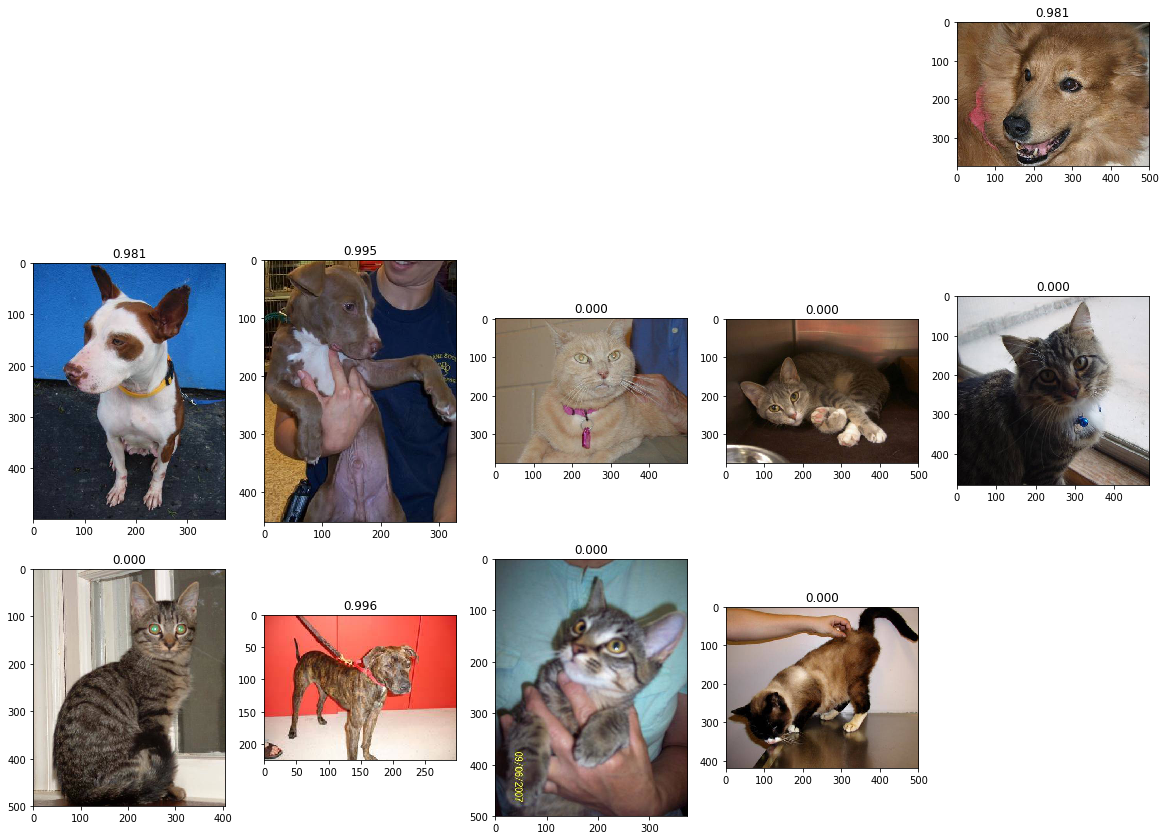

In [161]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [135]:
np.argmax(score)

0

## Готовим данные для сабмита

In [162]:
with open('submit9.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score ))